# Law, Bias, and Algorithms
## Algorithmic fairness (1/2)

In 2016, ProPublica published a [now-famous article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) analyzing and criticizing the lack of fairness in a risk assessment tool used nation-wide called COMPAS.
Here, we will take a look at a cleaned-up version of the COMPAS data that ProPublica used, and try to better understand algorithmic fairness by investigating the claims ProPublica made, along with the [counter claims](https://www.propublica.org/article/technical-response-to-northpointe) made by NorthPointe (now re-branded as [Equivant](https://www.equivant.com/)).

While NorthPointe claims their algorithm does not use race information (anti-classification) as part of their model and their model is calibrated across racial groups (calibration), ProPublica points out that their model actually differs in false positive rates for different racial groups (classification parity).
In this notebook, we will examine some of their claims through building and evaluating our own risk assessment model.

In [2]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Read the data
compas_df <- read_rds("../data/compas.rds")

## COMPAS data

A cleaned version of the COMPAS data is loaded as `compas_df`, with the following columns

* `id`: unique identifiers for each case
* `sex`, `dob`, `age`, `race`: demographic information for each defendant
* `recid_score`, `violence_score`: COMPAS scores assessing risk that a defendant will recidivate (`violence_score` for violent crimes) within two years of release (higher score correspond to higher risk)
* `priors_count`: number of prior arrests
* `is_recid`, `is_violent_recid`: Indicator variable that is `1` if the defendant was arrested for a new (violent) crime within two years of release, and `0` otherwise.

In [70]:
head(compas_df)

id,sex,dob,age,race,recid_score,violence_score,priors_count,is_recid,is_violent_recid,risk,pred_risk_score,pred_recid,compas_pred_recid
<dbl>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
3,Male,1982-01-22,34,African-American,3,1,0,1,1,0.365,4,FALSE,FALSE
4,Male,1991-05-14,24,African-American,4,3,4,1,0,0.641,6,TRUE,FALSE
5,Male,1993-01-21,23,African-American,8,6,1,0,0,0.535,5,TRUE,TRUE
8,Male,1974-07-23,41,Caucasian,6,2,14,1,0,0.800,8,TRUE,TRUE
10,Female,1976-06-03,39,Caucasian,1,1,0,0,0,0.311,3,FALSE,FALSE
13,Male,1994-06-10,21,Caucasian,3,5,1,1,1,0.559,6,TRUE,FALSE


### Exercise 1: Build a recidivism risk assessment model
We will start our exercise by building a risk assessment model using only prior arrests (`priors_count`) and age (`age`) to estimate if a defendant is going recidivate (`is_recid`).

In [79]:
# Build a logistic regression model estimating recidivism probability

# WRITE CODE HERE
# START solution
recid_model <- glm(is_recid ~ priors_count + age, data = compas_df, family="binomial")
# END solution

In order to assess our model's accuracy by comparing to the observed recidivism behavior,
we will need to choose a threshold where we will say all defendents with risks equal or above that threshold is likely to recidivate while those with risks below that threshold will not.
We can similarly evaluate the accuracy of the COMPAS model using their recidivism score (`recid_score`) assigned to individual defendant.

Now, let's calculate our model's accuracy and compare it to the accuracy of the COMPAS recidivism score. For this exercise, we will use $0.5$ as our model's threshold and $4$ for the COMPAS recidivism score.

In [81]:
# WRITE CODE HERE
# START solution
compas_df <- compas_df %>%
    mutate(
        risk = predict(recid_model, type="response"),
        pred_recid = risk >= 0.5,
        compas_pred_recid = recid_score >= 4
    )

# Calculate accuracy
compas_df %>%
    summarize(
        accuracy = mean(pred_recid == is_recid),
        compas_accuracy = mean(compas_pred_recid == is_recid)
    )
# END solution

accuracy,compas_accuracy
<dbl>,<dbl>
0.675,0.643


### Exercise 2: Calibration

Next, we will examine how well our model is calibrated accorss different racial groups,
i.e., for people that receive similar risk scores, what is the actual recidivism rate for each racial group.

To do so, we will calculate two quantities:
* `predicted_risk_score` is the discretized version of our predicted risk from exercise 1 like the COMPAS risk score;
* `recidivism_rate` is the actual recidivism rate of people with that specific discretized risk score.

Calculate the above two quantities for both racial groups in our dataset by creating a data frame called `calibration_by_race` containing three columns: `race`, `predicted_risk_score`, `recidivism_rate`.


_hint_: `round(x)` will round each element of `x` to the nearest integer.

In [112]:
# Calculate discretized risk score

calibration_by_race = compas_df %>%
# WRITE CODE HERE
# START solution
    mutate(predicted_risk_score = round(risk * 10)) %>%
    group_by(race, predicted_risk_score) %>%
    summarize(
        recidivism_rate = mean(is_recid)
    )
# END solution

# Put the recidivism rates of different races side by side
calibration_by_race %>%
    spread(race, recidivism_rate)

predicted_risk_score,African-American,Caucasian
<dbl>,<dbl>,<dbl>
1,0.148,0.150
2,0.266,0.197
3,0.279,0.306
4,0.354,0.398
5,0.472,0.436
6,0.707,0.590
7,0.757,0.790
8,0.788,0.768
9,0.856,0.800


We can visualize how well model is calibrated by running following code snippet:

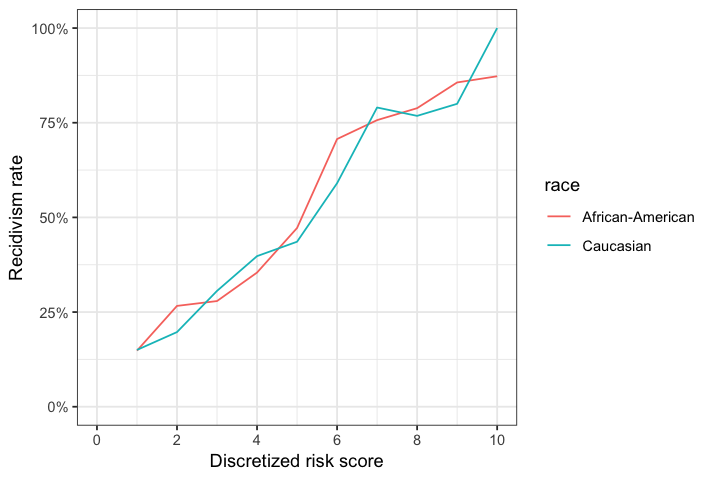

In [113]:
# Calibration plot
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(calibration_by_race, aes(x=predicted_risk_score, y=recidivism_rate, color=race)) +
    geom_line() + 
    scale_y_continuous(labels = scales::percent_format(1), limits=c(0, 1))+
    scale_x_continuous(breaks=seq(0, 10, 2), limits=c(0, 10))+
    labs(
        x = "Discretized risk score",
        y = "Recidivism rate"        
    )

The plot above suggets our model is well calibrated for and Caucasian defendants.
In other words, an African-American defendant that receives the same score as a Caucasian defendant in our dataset will have the same probability of recidivating.

### Exercise 3: Cost-benefit analysis

Detaining an individual costs a substaintial amount of social resources, yet releasing a defendant will introduce the possibility of the person commiting another crime.
Ideally, we would like to detain individuals with high recidivism risk while release those with low recidivism risk.
In order to make such a detention policy based on our model, we need to decide on a detention threshold of our estimated risk.

Specificially, we would like to know given a detention threshold,
what proportion of crimes will be prevented (i.e., what proportion of defendants that will commit another crime are detained) at what detention cost (i.e., what proportion of defendants are detained)?

For this exercise, complete the following function that takes in a threshold and returns a data frame including two columns: `prop_crime_prevented` and `prop_detained`.

In [20]:
calc_cost_benefit <- function(threshold){
# WRITE CODE HERE
# START solution
    compas_df %>%
        mutate(detained = risk > threshold) %>%
        summarize(
            num_crime_prevented = sum(is_recid & detained),
            prop_crime_prevented = num_crime_prevented/sum(is_recid),
            num_detained = sum(detained),
            prop_detained = num_detained/n()
        )    
# END solution
}

calc_cost_benefit(threshold = 0.5)

num_crime_prevented,prop_crime_prevented,num_detained,prop_detained
<int>,<dbl>,<int>,<dbl>
2073,0.677,3084,0.501


We can plot this cost-benefit tradeoff for all possible detention threshold by running following code:

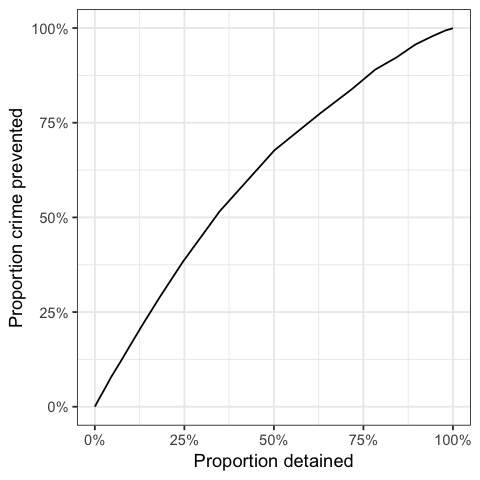

In [116]:
thresholds = seq(0, 1, 0.05)
cost_benefit_df <- map_dfr(seq(0, 1, 0.05), 
                           ~calc_cost_benefit(.)) %>%
    mutate(threshold = thresholds)

# Plot proportion detained vs. proportion crime prevented
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(cost_benefit_df, aes(x=prop_detained, y=prop_crime_prevented)) +
    geom_line()+
    scale_y_continuous(labels = scales::percent_format(1), limits=c(0, 1))+
    scale_x_continuous(labels = scales::percent_format(1), limits=c(0, 1))+
    labs(
        x = "Proportion detained",
        y = "Proportion crime prevented"        
    )

### Exercise 4: Detention disparate impact

By conducting the above cost-benefit analysis,
we can decide on a detention threshold, say $0.5$, that we believe can maximize our benefit (crime prevention) at a acceptable cost of detaining some of the riskests defendants according to our model.

Now we would like to know, whether such facially neutral policy where we detain everyone with the same threshold will introduce disparate impact on different races.

To do so, let's compute the dentention rate and recidivism rate for each racial group using a detention threshold of 0.5.

In [117]:
# Calculate detention and recidivism rate by race

# WRITE CODE HERE
# START solution
compas_df %>%
    mutate(detained = risk > 0.5) %>%
    group_by(race) %>%
    summarize(
        detention_rate = mean(detained),
        recidivism_rate = mean(is_recid)
    )
# END solution

race,detention_rate,recidivism_rate
<chr>,<dbl>,<dbl>
African-American,0.604,0.551
Caucasian,0.347,0.418


Despite the same detention threshold is being used, we still observe a different dentention rate as well as recidivism rate, suggesting a disparate impact against African-American defendents.

To explain this, we will plot the risk distribution for the two groups:

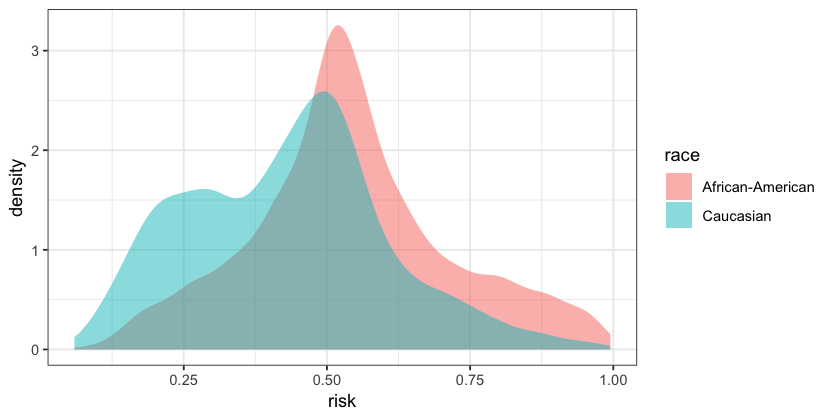

In [121]:
# Plot the risk distribution
options(repr.plot.width = 7, repr.plot.height = 3.5)
ggplot(compas_df, aes(x=risk, fill=race)) +
    geom_density(alpha=0.5, color=NA)

Assume our model provide an accurate risk assessment, we see that African-American and Caucasian defendents do not share the same underlying risk distribution:
African-American defendants' risk distribution is more heavy-tailed on the higher end.
When we are making a policy decision, usually we are mostly concerned with what happens at the margin (e.g., whether the same standard is applied to all individuals).
What happens at the margin also determines whether decisions maximize social welfare,
with the optimal threshold set at the point where the marginal benefits equal the marginal costs.  However, popular error metrics assess behavior away from the margin, hence they are called infra-marginal statistics.
Hence, this general phenomenon is known as the problem of _infra-marginality_ (Ayres, 2002; Simoiu et al., 2017; Corbett-Davies and Goel, 2018).

### Exercise 5: Equalizing detaintion rates

After we realize this problem of infra-marginality,
we are curious to see what a policy that equalizes the detention rate for each group will be like by applying different detention thrsholds to differrent group.

In this exercise, test with different thresholds for African-American and Caucasian defendants to achieve around 50% dentention rate for each group.

In [69]:
black_threshold = 0.5
white_threshold = 0.5

# WRITE CODE HERE
# START solution
black_threshold = 0.53
white_threshold = 0.44
# END solution

# Calculate detention and recidivism rate by race
compas_df %>%
    mutate(detained = risk > ifelse(race == "Caucasian", white_threshold, black_threshold)) %>%
    group_by(race) %>%
    summarize(
        detention_rate = mean(detained),
        recidivism_rate = mean(is_recid)
    )


race,detention_rate,recidivism_rate
<chr>,<dbl>,<dbl>
African-American,0.500,0.551
Caucasian,0.501,0.418
